In [18]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [19]:
batch_sz = 8

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_sz,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=True, num_workers=2)

classes = [i for i in range(10)]

    5     0     7     9


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x11a732940>>
Traceback (most recent call last):
  File "/Users/silver/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/Users/silver/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/silver/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/Users/silver/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 86, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/minicondabuild3/conda-bld/pytorch_1524590658547/work/torch/lib/libshm/core.cpp:125


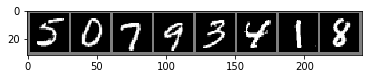

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [21]:
#https://github.com/pytorch/tutorials/blob/master/beginner_source/former_torchies/nn_tutorial.py

# -*- coding: utf-8 -*-
"""
nn package
==========
We’ve redesigned the nn package, so that it’s fully integrated with
autograd. Let's review the changes.
**Replace containers with autograd:**
    You no longer have to use Containers like ``ConcatTable``, or modules like
    ``CAddTable``, or use and debug with nngraph. We will seamlessly use
    autograd to define our neural networks. For example,
    * ``output = nn.CAddTable():forward({input1, input2})`` simply becomes
      ``output = input1 + input2``
    * ``output = nn.MulConstant(0.5):forward(input)`` simply becomes
      ``output = input * 0.5``
**State is no longer held in the module, but in the network graph:**
    Using recurrent networks should be simpler because of this reason. If
    you want to create a recurrent network, simply use the same Linear layer
    multiple times, without having to think about sharing weights.
    .. figure:: /_static/img/torch-nn-vs-pytorch-nn.png
       :alt: torch-nn-vs-pytorch-nn
       torch-nn-vs-pytorch-nn
**Simplified debugging:**
    Debugging is intuitive using Python’s pdb debugger, and **the debugger
    and stack traces stop at exactly where an error occurred.** What you see
    is what you get.
Example 1: ConvNet
------------------
Let’s see how to create a small ConvNet.
All of your networks are derived from the base class ``nn.Module``:
-  In the constructor, you declare all the layers you want to use.
-  In the forward function, you define how your model is going to be
   run, from input to output
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class MNISTConvNet(nn.Module):

    def __init__(self):
        # this is the place where you instantiate all your modules
        # you can later access them using the same names you've given them in
        # here
        super(MNISTConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)  
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(320, 50) #320
        self.fc2 = nn.Linear(50, 10)

    # it's the forward function that defines the network structure
    # we're accepting only a single input in here, but if you want,
    # feel free to use more
    def forward(self, input):
        x = self.pool1(F.relu(self.conv1(input)))
        x = self.pool2(F.relu(self.conv2(x)))

        # in your model definition you can go full crazy and use arbitrary
        # python code to define your model structure
        # all these are perfectly legal, and will be handled correctly
        # by autograd:
        # if x.gt(0) > x.numel() / 2:
        #      ...
        #
        # you can even do a loop and reuse the same module inside it
        # modules no longer hold ephemeral state, so you can use them
        # multiple times during your forward pass
        # while x.norm(2) < 10:
        #    x = self.conv1(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

###############################################################
# Let's use the defined ConvNet now.
# You create an instance of the class first.


net = MNISTConvNet()
print(net)

########################################################################
# .. note::
#
#     ``torch.nn`` only supports mini-batches The entire ``torch.nn``
#     package only supports inputs that are a mini-batch of samples, and not
#     a single sample.
#
#     For example, ``nn.Conv2d`` will take in a 4D Tensor of
#     ``nSamples x nChannels x Height x Width``.
#
#     If you have a single sample, just use ``input.unsqueeze(0)`` to add
#     a fake batch dimension.


MNISTConvNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [22]:
#PRINTS FOR DAYS


########################################################################
# The output of the ConvNet ``out`` is a ``Tensor``. We compute the loss
# using that, and that results in ``err`` which is also a ``Tensor``.
# Calling ``.backward`` on ``err`` hence will propagate gradients all the
# way through the ConvNet to it’s weights
#
# Let's access individual layer weights and gradients:

# print("THIS IS CONV1 WEIGHT GRAD SIZE")
# print(net.conv1.weight.grad.size())

# print("THIS IS CONV1 WEIGHT GRAD")
# print(net.conv1.weight.grad)

#'MaxPool2d' object has no attribute 'weight'
# print("THIS IS POOL1 WEIGHT GRAD SIZE")
# print(net.pool1.weight.grad.size())

# print("THIS IS POOL1 WEIGHT GRAD")
# print(net.pool1.weight.grad)


# print("THIS IS CONV2 WEIGHT GRAD SIZE")
# print(net.conv2.weight.grad.size())

# print("THIS IS CONV2 WEIGHT GRAD")
# print(net.conv2.weight.grad)

# print("THIS IS FC1 WEIGHT GRAD SIZE")
# print(net.fc1.weight.grad.size())

# print("THIS IS FC1 WEIGHT GRAD")
# print(net.fc1.weight.grad)

# print("THIS IS FC2 WEIGHT GRAD SIZE")
# print(net.fc2.weight.grad.size())

# print("THIS IS FC2 WEIGHT GRAD")
# print(net.fc2.weight.grad)

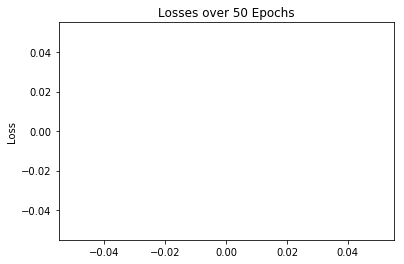

In [23]:
plt.plot(losses)
plt.title("Losses over 50 Epochs")
plt.ylabel('Loss')
plt.show()

GroundTruth:      1


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x11a8be9e8>>
Traceback (most recent call last):
  File "/Users/silver/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/Users/silver/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/silver/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/Users/silver/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 86, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/minicondabuild3/conda-bld/pytorch_1524590658547/work/torch/lib/libshm/core.cpp:125


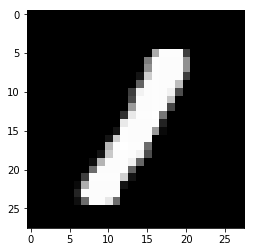

In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [9]:
#suppose i am interested in first layer
print(net.conv1.weight.grad)

# #outputs = net(images)#forward pass

# print(outputs)
# loss = criterion(outputs, labels)
# print(loss.item())
# print(net.conv1.weight.data.grad)
# print(net.conv1.weight.data)


tensor(1.00000e-02 *
       [[[[-0.3610, -0.3067, -0.0403,  0.1137,  0.3347],
          [-0.4493, -0.3533,  0.0710,  0.1550,  0.2200],
          [-0.2805, -0.2704, -0.0578, -0.0779, -0.3863],
          [-0.3973, -0.6161, -0.3356, -0.3386, -0.4498],
          [-0.5127, -0.7174, -0.3586, -0.1728, -0.1808]]],


        [[[-0.7713, -0.5443, -0.3521, -0.0249,  0.1743],
          [-0.3638, -0.5876,  0.0627,  0.1811, -0.0269],
          [-0.1599,  0.0050,  0.3481,  0.1462,  0.0620],
          [-0.0140,  0.3630,  0.3227,  0.0829,  0.0544],
          [ 0.2105,  0.3383,  0.2487,  0.2510, -0.2286]]],


        [[[-0.0326, -0.1504,  0.0510,  0.2032,  0.1187],
          [ 0.0535,  0.2045,  0.2156,  0.0697, -0.0173],
          [-0.0432,  0.3125,  0.2915,  0.2472,  0.2052],
          [ 0.0249,  0.2896,  0.4818,  0.6258,  0.4809],
          [ 0.0581,  0.2810,  0.6598,  0.8535,  0.5637]]],


        [[[ 0.4310,  0.3095,  0.4343,  0.4968,  0.5473],
          [ 0.6265,  0.8177,  0.5257,  0.3599,  0.6427]

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(1)))

Predicted:      8
